In [ ]:
!pip install openpyxl tqdm python-docx openai
!pip install scikit-learn rouge-score sacrebleu
!pip install nltk bert-score
!pip install fireducks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c2d0526dea861984a3d6189fcf4be9f53ef3dde40f0b809f04037454fda63ffa
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [ ]:
import os, re, json, glob
import pandas as pd
import fireducks as fd
from tqdm import tqdm
from openai import OpenAI
from docx import Document
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Access the API key securely from Colab's Userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
# path to input JSONs and output folder
excel_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Radiology-manual-annotations.xlsx"
INPUT_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Medical reports for cases/"
OUTPUT_DIR = r"/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive"
OUTPUT_IMG_DIR = r"/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-Images"
INPUT_IMG_DIR= "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG-CDD-CESM/CDD-CESM/"

# checks output directory is real
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
xl = pd.ExcelFile(excel_path)

frames = []
for sheet in xl.sheet_names:
    tmp = xl.parse(sheet)
    tmp["__sheet__"] = sheet  # remember which sheet the row came from
    frames.append(tmp)

df = pd.concat(frames, ignore_index=True)

print(df.columns)

Index(['Image_name', 'Patient_ID', 'Side', 'Type', 'Age',
       'Breast density (ACR)', 'BIRADS', 'Findings', 'View', 'Tags', 'Machine',
       'Pathology Classification/ Follow up', '__sheet__', 'Abnormality type',
       'Single/Multiple', 'Mass density/enhancement pattern', 'Mass shape',
       'Mass margin', 'ACR'],
      dtype='object')


In [ ]:
# After loading df
all_patient_ids = sorted(df["Patient_ID"].dropna().unique())
print(f"Total patients: {len(all_patient_ids)}")  # Should be 326

Total patients: 326


In [ ]:
from sklearn.model_selection import train_test_split

# Use the SAME random_state as before (42)
train_ids, temp_ids = train_test_split(
    all_patient_ids,
    test_size=0.20,  # 65.2 → 66 patients for val+test
    random_state=42
)

val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.50,  # 33 val, 33 test
    random_state=42
)

print(f"Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")
# Output: Train: 260 | Val: 33 | Test: 33

Train: 260 | Val: 33 | Test: 33


In [ ]:
# Convert np.int64 to native int for JSON compatibility
test_ids_native = [int(pid) for pid in test_ids]

with open("test_patient_ids.json", "w") as f:
    json.dump(sorted(test_ids_native), f)

print("Test patient IDs saved to 'test_patient_ids.json'")

Test patient IDs saved to 'test_patient_ids.json'


In [ ]:
import os, glob

LOW_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG - CDD-CESM/CDD-CESM/LowEnergyImg_CDDCESM"
SUB_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG - CDD-CESM/CDD-CESM/SubImg_CDDCESM"
IMG_DIRS = [LOW_DIR, SUB_DIR]

for d in IMG_DIRS:
    print(d, "-> exists?", os.path.exists(d))

# peek at a few files from each folder (recursive)
for d in IMG_DIRS:
    files = glob.glob(os.path.join(d, "**", "*"), recursive=True)
    files = [f for f in files if os.path.isfile(f)]
    print("\nSample files in:", d)
    for f in files[:10]:
        print(" -", os.path.basename(f))

/content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG - CDD-CESM/CDD-CESM/LowEnergyImg_CDDCESM -> exists? True
/content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG - CDD-CESM/CDD-CESM/SubImg_CDDCESM -> exists? True

Sample files in: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG - CDD-CESM/CDD-CESM/LowEnergyImg_CDDCESM
 - P101_L_DM_MLO.jpg
 - P101_L_DM_CC.jpg
 - P100_R_DM_CC.jpg
 - P101_R_DM_MLO.jpg
 - P100_L_DM_CC.jpg
 - P101_R_DM_CC.jpg
 - P100_R_DM_MLO.jpg
 - P102_L_DM_CC.jpg
 - P103_R_DM_CC.jpg
 - P102_L_DM_MLO.jpg

Sample files in: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/PKG - CDD-CESM/CDD-CESM/SubImg_CDDCESM
 - P100_L_CM_MLO.jpg
 - P101_L_CM_CC.jpg
 - P101_L_CM_MLO.jpg
 - P100_L_CM_CC.jpg
 - P101_R_CM_MLO.jpg
 - P101_R_CM_CC.jpg
 - P102_R_CM_CC.jpg
 - P102_L_CM_MLO.jpg
 - P102_R_CM_MLO.jpg
 - P103_L_CM_CC.jpg


In [ ]:
import re, os

def extract_pid(filepath_or_name: str):
    base = os.path.basename(filepath_or_name)          # "P99_R_DM_MLO.png"
    stem = os.path.splitext(base)[0]                   # "P99_R_DM_MLO"
    first = re.split(r"[_\s-]+", stem)[0]              # "P99"
    m = re.match(r"(?i)^P0*(\d+)$", first)             # digits after P
    return int(m.group(1)) if m else None

In [ ]:
from collections import defaultdict

IMG_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tif", ".tiff"}

def build_patient_image_index(img_dirs):
    idx = defaultdict(list)
    skipped = []

    for root in img_dirs:
        for dirpath, _, files in os.walk(root):
            for fn in files:
                ext = os.path.splitext(fn)[1].lower()
                if ext not in IMG_EXTS:
                    continue

                full = os.path.join(dirpath, fn)
                pid = extract_pid(fn)   # filename is enough
                if pid is None:
                    skipped.append(full)
                    continue

                idx[pid].append(full)

    # de-dupe + sort
    for pid in list(idx.keys()):
        idx[pid] = sorted(list(dict.fromkeys(idx[pid])))

    return dict(idx), skipped

patient_images, skipped_files = build_patient_image_index(IMG_DIRS)

print("Patients with images:", len(patient_images))
print("Unmatched image files:", len(skipped_files))

# show a couple patients
for pid in sorted(patient_images.keys())[:5]:
    print(pid, "->", len(patient_images[pid]), "images; ex:", os.path.basename(patient_images[pid][0]))

# show a couple skipped (if any)
print("\nFirst 10 skipped:")
for s in skipped_files[:10]:
    print(" -", os.path.basename(s))

Patients with images: 324
Unmatched image files: 0
1 -> 2 images; ex: P1_L_DM_MLO.jpg
2 -> 5 images; ex: P2_L_DM_CC.jpg
3 -> 5 images; ex: P3_L_DM_MLO.jpg
4 -> 4 images; ex: P4_L_DM_MLO.jpg
5 -> 5 images; ex: P5_L_DM_CC.jpg

First 10 skipped:


In [ ]:
import json, os

OUT_INDEX = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output_JSON/patient_image_index.json"
os.makedirs(os.path.dirname(OUT_INDEX), exist_ok=True)

with open(OUT_INDEX, "w") as f:
    json.dump({str(k): v for k, v in patient_images.items()}, f, indent=2)

print("Saved index to:", OUT_INDEX)

Saved index to: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output_JSON/patient_image_index.json


In [ ]:
from docx import Document

def save_text_as_docx(text: str, out_path: str) -> None:
    doc = Document()
    for line in (text or "").splitlines():
        doc.add_paragraph(line)
    doc.save(out_path)

def call_gpt_text(prompt_text: str) -> str:
    resp = client.responses.create(
        model="gpt-5",
        reasoning={"effort": "medium"},
        input=[{"role": "user", "content": prompt_text}],
        max_output_tokens=8000,
    )
    return resp.output_text


In [ ]:
import json

def generate_report_from_json(patient_json: dict) -> str:
    response = client.responses.create(
        model="gpt-5",
        reasoning={"effort": "medium"},
        input=[
            {"role": "system", "content": NAIVE_ANNO_PROMPT},
            {"role": "user", "content": json.dumps(patient_json)},
        ],
        max_output_tokens=10000,
    )

    # New Responses API: output is a list that can contain
    # reasoning items *and* message items. We want the message.
    out = getattr(response, "output", None)
    if out:
        # search for the message item
        for item in out:
            item_type = getattr(item, "type", None)
            # message payload is in the ResponseOutputMessage
            if item_type == "message" or item.__class__.__name__ == "ResponseOutputMessage":
                contents = getattr(item, "content", []) or []
                text_chunks = []
                for c in contents:
                    c_type = getattr(c, "type", None)
                    if c_type == "output_text" or c.__class__.__name__ == "ResponseOutputText":
                        text_chunks.append(getattr(c, "text", ""))
                full_text = "".join(text_chunks).strip()
                if full_text:
                    return full_text

    # Fallbacks if structure ever changes
    # 1) Sometimes there may be a top-level .text string
    txt = getattr(response, "text", None)
    if isinstance(txt, str):
        return txt.strip()

    # 2) Legacy choices/message style (rare, but harmless to keep)
    choices = getattr(response, "choices", None)
    if choices:
        choice0 = choices[0]
        if hasattr(choice0, "message"):
            msg = choice0.message
            if isinstance(msg, dict) and "content" in msg:
                return str(msg["content"]).strip()
        if hasattr(choice0, "text"):
            return str(choice0.text).strip()

    # show the whole response for debugging
    print("Unexpected response format from API:")
    print(response)
    raise RuntimeError("Could not extract text from GPT response; see printed response above.")

In [ ]:
import pandas as pd, os, json
from tqdm import tqdm

NAIVE_ANNO_OUTPUT = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive-anno"
os.makedirs(NAIVE_ANNO_OUTPUT, exist_ok=True)

NAIVE_ANNO_PROMPT = """
You are an expert breast imaging radiologist.
Generate a BI-RADS-compliant radiology report from the findings below.

Do NOT invent any findings not listed. If unsure, state "Cannot determine."

Findings:
{raw_annotation_text}
"""

def build_raw_annotation_text(patient_group: pd.DataFrame) -> str:
    findings = patient_group["Findings"].dropna().astype(str).tolist()
    # optional de-dupe:
    seen, deduped = set(), []
    for f in findings:
        if f not in seen:
            deduped.append(f); seen.add(f)
    return " | ".join(deduped) if deduped else "No findings provided."

with open("test_patient_ids.json", "r") as f:
    test_ids = json.load(f)

groups = df.groupby("Patient_ID", sort=False)

for pid in tqdm(test_ids, desc="NAIVE ANNO reports"):
    pid = int(pid)
    out_path = os.path.join(NAIVE_ANNO_OUTPUT, f"P{pid}_naive_anno.docx")
    if os.path.exists(out_path):
        continue

    patient_group = groups.get_group(pid) if pid in groups.groups else df.iloc[0:0]
    raw_text = build_raw_annotation_text(patient_group)

    report = call_gpt_text(NAIVE_ANNO_PROMPT.format(raw_annotation_text=raw_text))
    save_text_as_docx(report, out_path)

NAIVE ANNO reports: 100%|██████████| 33/33 [19:39<00:00, 35.74s/it]


In [ ]:
import base64
from io import BytesIO
from PIL import Image

def image_to_data_url(path: str, max_side: int = 1024, jpeg_quality: int = 85) -> str:
    img = Image.open(path).convert("RGB")
    w, h = img.size
    scale = min(1.0, max_side / max(w, h))
    if scale < 1.0:
        img = img.resize((int(w * scale), int(h * scale)))

    buf = BytesIO()
    img.save(buf, format="JPEG", quality=jpeg_quality, optimize=True)
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{b64}"

IMAGE_REPORT_PROMPT = """You are an expert breast imaging radiologist.
Write a BI-RADS-style report based ONLY on the provided images.

If you cannot confidently determine something, write "Unknown" (do NOT guess).

Patient ID: {patient_id}
"""

def call_gpt_with_images(patient_id: int, img_paths: list[str], max_images: int = 8) -> str:
    img_paths = img_paths[:max_images]

    content = [{"type": "input_text", "text": IMAGE_REPORT_PROMPT.format(patient_id=patient_id)}]
    for p in img_paths:
        content.append({"type": "input_image", "image_url": image_to_data_url(p)})

    resp = client.responses.create(
        model="gpt-5",
        reasoning={"effort": "medium"},
        input=[{"role": "user", "content": content}],
        max_output_tokens=8000,
    )
    return resp.output_text


In [ ]:
test_pid = sorted(patient_images.keys())[0]
print("Testing pid:", test_pid)
print("Image count:", len(patient_images[test_pid]))
for p in patient_images[test_pid][:5]:
    print(" -", os.path.basename(p))

report = call_gpt_with_images(test_pid, patient_images[test_pid], max_images=6)
print(report[:1000])


Testing pid: 1
Image count: 2
 - P1_L_DM_MLO.jpg
 - P1_L_CM_MLO.jpg
Patient ID: 1

Exam type: Mammography (2D). Views provided: CC and MLO of a single breast. Laterality: Unknown.
Clinical indication: Unknown.
Comparison: Unknown.

Breast composition (ACR density): C – heterogeneously dense, which may obscure small masses.

Findings:
- Possible mass: A round to oval, circumscribed, equal-density focus is seen on the MLO view in the anterior depth near the skin along the inferior/central breast. This finding is not confidently identified on the CC view.
- No associated architectural distortion or suspicious grouped calcifications identified in the area of concern on the provided images.
- Scattered benign-appearing calcifications are present.
- Superficial skin/nipple marker is present on the CC view; relationship to the MLO finding is Unknown.

Impression:
Incomplete evaluation. Possible mass seen on MLO only; CC correlation is Unknown.

Recommendation:
- Diagnostic mammography of the 

In [ ]:
NAIVE_IMAGE_OUTPUT = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive-image"
os.makedirs(NAIVE_IMAGE_OUTPUT, exist_ok=True)

for pid in tqdm(test_ids, desc="IMAGE reports"):
    pid = int(pid)
    out_path = os.path.join(NAIVE_IMAGE_OUTPUT, f"P{pid}_naive_image.docx")
    if os.path.exists(out_path):
        continue

    imgs = patient_images.get(pid, [])
    if not imgs:
        save_text_as_docx("No images found for this patient in the image folders.", out_path)
        continue

    report = call_gpt_with_images(pid, imgs, max_images=8)
    save_text_as_docx(report, out_path)


IMAGE reports: 100%|██████████| 33/33 [34:07<00:00, 62.05s/it]


In [ ]:
!pip install rouge-score sacrebleu bert-score python-docx scikit-learn

In [ ]:
GT_DIR = INPUT_DIR   # Medical reports for cases
GEN_DIR = OUTPUT_DIR # Output

from docx import Document

def docx_to_text(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs)


In [ ]:
!pip install nltk bert-score

In [ ]:
import nltk
nltk.download('punkt_tab')  # Required for METEOR tokenization

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import nltk
packages = ['punkt', 'wordnet', 'stopwords']  # Add more as needed
for pkg in packages:
    try:
        nltk.data.find(f'corpora/{pkg}' if pkg != 'punkt' else f'tokenizers/{pkg}')
    except LookupError:
        nltk.download(pkg)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import os, re
import pandas as pd
from tqdm import tqdm
from docx import Document

from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn

from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
import os, re, json
from docx import Document

def read_docx_text(path: str) -> str:
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs).strip()

def read_text_any(path: str) -> str:
    if path.lower().endswith(".docx"):
        return read_docx_text(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read().strip()

def extract_pid_from_filename(filename: str):
    m = re.search(r"(?i)P0*(\d+)", filename)
    return int(m.group(1)) if m else None

def load_reports(folder: str):
    out = {}
    for fn in os.listdir(folder):
        if fn.startswith("~$"):   # <-- skip Word temp files
            continue
        if not fn.lower().endswith(".docx"):
            continue

        pid = extract_pid_from_filename(fn)
        if pid is None:
            continue

        path = os.path.join(folder, fn)
        out[pid] = read_docx_text(path)

    return out


In [ ]:
GT_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Medical reports for cases"
NAIVE_ANNO_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive-anno"
NAIVE_IMG_DIR  = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive-image"
STRICT_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2"

with open("test_patient_ids.json", "r") as f:
    test_ids = [int(x) for x in json.load(f)]

print("Test IDs:", len(test_ids))
print("GT exists:", os.path.exists(GT_DIR))
print("naive-anno exists:", os.path.exists(NAIVE_ANNO_DIR))
print("naive-img exists:", os.path.exists(NAIVE_IMG_DIR))
print("strict-output exists:", os.path.exists(STRICT_DIR))

Test IDs: 33
GT exists: True
naive-anno exists: True
naive-img exists: True
strict-output exists: True


In [ ]:
gt        = load_reports(GT_DIR)
naive_anno = load_reports(NAIVE_ANNO_DIR)
naive_img  = load_reports(NAIVE_IMG_DIR)
strict     = load_reports(STRICT_DIR)

print("GT:", len(gt))
print("naive-anno:", len(naive_anno))
print("naive-img:", len(naive_img))
print("strict:", len(strict))


GT: 326
naive-anno: 33
naive-img: 33
strict: 326


In [ ]:
with open("test_patient_ids.json", "r") as f:
    test_ids = [int(x) for x in json.load(f)]

ids_all = sorted([
    pid for pid in test_ids
    if pid in gt and pid in strict and pid in naive_anno and pid in naive_img
])

print("Patients usable for ALL systems:", len(ids_all))

Patients usable for ALL systems: 33


In [ ]:
def eval_ids_for(pred_map):
    return [pid for pid in test_ids if pid in gt and pid in pred_map]

ids_strict = eval_ids_for(strict)
ids_anno   = eval_ids_for(naive_anno)
ids_img    = eval_ids_for(naive_img)

print("Usable STRICT patients:", len(ids_strict))
print("Usable naive-anno patients:", len(ids_anno))
print("Usable naive-img patients:", len(ids_img))

Usable STRICT patients: 33
Usable naive-anno patients: 33
Usable naive-img patients: 33


In [ ]:
ids_all = sorted(set(ids_strict) & set(ids_anno) & set(ids_img))
print("Patients usable for ALL (STRICT + ANNO + IMG):", len(ids_all))


Patients usable for ALL (STRICT + ANNO + IMG): 33


columns

ROUGE: Recall-Oriented Understudy for Gisting Evaluation. It's a set of metrics for evaluating automatic summarization and machine translation.

rouge1_f: This measures the overlap of unigrams (single words) between the generated text and the reference text. alongside, F-score, which is the harmonic mean of Precision and Recall. It gives a balanced score that considers both how many correct words were generated (Precision) and how many of the reference words were captured (Recall).

rougeL_f: measures the longest common subsequence (LCS) between the generated text and the reference text. It looks for the longest sequence of words that appear in order in both texts, even if they are not consecutive. Also, alongside with F-score.

bleu: Bilingual Evaluation Understudy, evaluating the quality of text that has been machine-translated from one natural language to another. It calculates a modified precision score based on n-gram overlaps (usually up to 4-grams). It also includes a brevity penalty to penalize translations that are too short compared to the reference.

meteor: Metric for Evaluation of Translation with Explicit ORdering. It was designed to address some of the shortcomings of BLEU. aligns words between the candidate and reference sentences, considering exact matches, stem matches, synonym matches, and paraphrase matches. It then calculates a harmonic mean of precision and recall, with a penalty for word order differences.

bertscore_f1: newer metric that uses contextual embeddings from the BERT language model to evaluate text generation. Instead of counting n-grams, it compares the semantic meaning of words by looking at their vector representations in a deep neural network (BERT). It calculates Precision, Recall, and F1 scores based on the cosine similarity between these embeddings

$$
\begin{aligned}
&\textbf{Evaluation Metrics Overview} \\
&\text{All metrics use F1 (harmonic mean of Precision and Recall).} \\
& \\
&\textbf{ROUGE} \\
&\quad \texttt{rouge1\_f}: \text{Unigram overlap F1.} \\
&\quad \texttt{rougeL\_f}: \text{LCS-based F1 (in-order fluency).} \\
& \\
&\textbf{BLEU} \\
&\quad \texttt{bleu}: \text{N-gram precision + brevity penalty.} \\
& \\
&\textbf{METEOR} \\
&\quad \texttt{meteor}: \text{Matches via synonyms/stems; penalizes word order.} \\
& \\
&\textbf{BERTScore} \\
&\quad \texttt{bertscore\_f1}: \text{Semantic similarity via BERT embeddings.} \\
& \\
&\textbf{Takeaway:} \text{ exact words or word forms (matching tokens) → BLEU/ROUGE; meaning, not wording → BERTScore.}
\end{aligned}
$$

$$
\begin{array}{|l|l|}
\hline
\textbf{Metric} & \textbf{Short Description} \\
\hline
\texttt{rougeL\_f} & \text{Measures overlap of longest common subsequences between generated \& reference text. Good for fluency \& structure.} \\
\hline
\texttt{bleu} & \text{Measures n-gram precision. Penalizes short outputs. Classic MT metric.} \\
\hline
\texttt{meteor} & \text{More nuanced than BLEU — considers synonyms, stemming, and word order. Better for meaning.} \\
\hline
\texttt{bertscore\_f1} & \text{Uses BERT embeddings to compare semantic similarity. Best for capturing meaning, not just words.} \\
\hline
\end{array}
$$

💡 $\texttt{rougeL\_f}$ and $\texttt{bleu}$ are older but still widely used.  
💡 $\texttt{meteor}$ and $\texttt{bertscore\_f1}$ are more modern and often better at capturing actual meaning.

In [ ]:
import re

def extract_birads_by_side(text: str):
    """
    Returns {'L': int or None, 'R': int or None}
    Tries to find a BI-RADS number near LEFT/RIGHT keywords.
    """
    t = (text or "").replace("\n", " ")
    out = {"L": None, "R": None}

    patterns = {
        "L": r"(?i)(left|lt)\b.{0,120}?\bbi\s*[-]?\s*rads\b[^0-9]{0,25}([0-6])",
        "R": r"(?i)(right|rt)\b.{0,120}?\bbi\s*[-]?\s*rads\b[^0-9]{0,25}([0-6])",
    }

    for side, pat in patterns.items():
        m = re.search(pat, t)
        if m:
            out[side] = int(m.group(2))

    # fallback: sometimes report says "RIGHT: BI-RADS 2" without the "BI-RADS" token exactly
    if out["L"] is None:
        m = re.search(r"(?i)\b(left|lt)\b.{0,120}?\b([0-6])\b", t)
        # only use fallback if you REALLY need it; can be noisy
    if out["R"] is None:
        m = re.search(r"(?i)\b(right|rt)\b.{0,120}?\b([0-6])\b", t)

    return out


In [ ]:
def build_birads_pairs_breast_level(ids, gt_map, pred_map, include_unknown=True):
    """
    Adds TWO entries per patient: Left and Right.
    If missing -> 0 if include_unknown else drop.
    """
    y_true, y_pred = [], []
    missing = 0
    total = 0

    for pid in ids:
        gt_sides = extract_birads_by_side(gt_map[pid])
        pr_sides = extract_birads_by_side(pred_map[pid])

        for side in ["L", "R"]:
            gt_b = gt_sides.get(side)
            pr_b = pr_sides.get(side)
            if gt_b is None:
                continue  # skip if GT doesn't have it

            total += 1
            if pr_b is None:
                missing += 1
                if include_unknown:
                    pr_b = 0
                else:
                    continue

            y_true.append(gt_b)
            y_pred.append(pr_b)

    coverage = 1 - (missing / total) if total else 0.0
    return y_true, y_pred, coverage


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format="d", ax=plt.gca(), cmap="Blues", colorbar=True)

    plt.title(title)
    plt.xlabel("Predicted BI-RADS")
    plt.ylabel("True BI-RADS")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return cm

STRICT breast-level n= 58 coverage= 100.0%


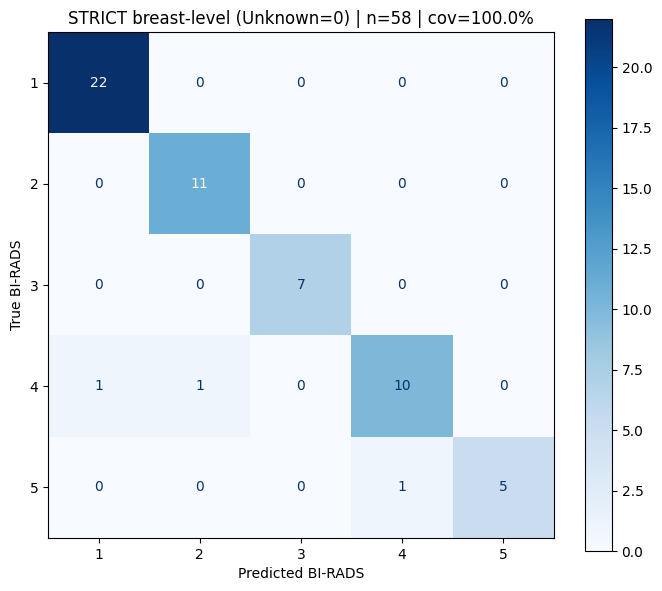

NAIVE-ANNO breast-level n= 58 coverage= 0.0%


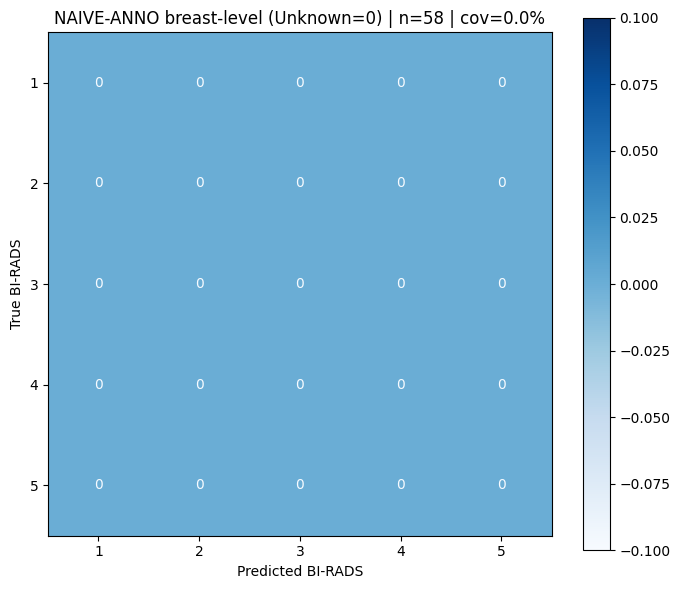

NAIVE-IMG breast-level n= 58 coverage= 3.4%


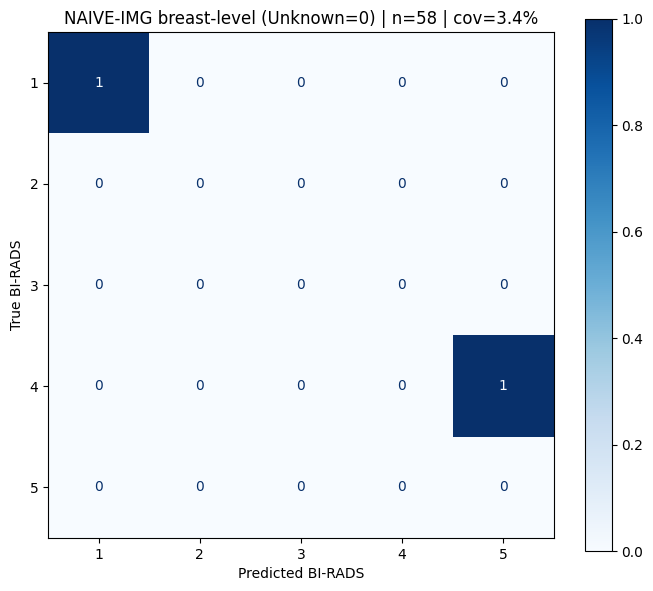

In [ ]:
labels_with_unknown = [1,2,3,4,5]

systems = [
    ("STRICT", strict),
    ("NAIVE-ANNO", naive_anno),
    ("NAIVE-IMG", naive_img),
]

for name, pred_map in systems:
    y_true, y_pred, cov = build_birads_pairs_breast_level(ids_all, gt, pred_map, include_unknown=True)
    print(name, "breast-level n=", len(y_true), "coverage=", f"{cov*100:.1f}%")
    plot_cm(y_true, y_pred, labels_with_unknown, f"{name} breast-level (Unknown=0) | n={len(y_true)} | cov={cov*100:.1f}%")


In [ ]:
from tqdm import tqdm
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn

def compute_text_metrics(pid_list, gt_map, pred_map, label: str):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

    rows, refs, hyps = [], [], []
    for pid in tqdm(pid_list, desc=f"Scoring {label}"):
        ref = gt_map[pid]
        hyp = pred_map[pid]

        r = scorer.score(ref, hyp)
        rouge1_f = r["rouge1"].fmeasure
        rougel_f = r["rougeL"].fmeasure
        bleu = sacrebleu.sentence_bleu(hyp, [ref]).score
        meteor = meteor_score([ref.split()], hyp.split())

        rows.append({
            "patient_id": pid,
            "rouge1_f": rouge1_f,
            "rougel_f": rougel_f,
            "bleu": bleu,
            "meteor": meteor,
        })
        refs.append(ref); hyps.append(hyp)

    # BERTScore (batch)
    P, R, F1 = bert_score_fn(hyps, refs, lang="en", rescale_with_baseline=True)
    for i in range(len(rows)):
        rows[i]["bertscore_f1"] = float(F1[i])

    df = pd.DataFrame(rows)
    df["system"] = label
    return df

# Use ids_all to ensure same patients across all
df_strict = compute_text_metrics(ids_all, gt, strict, "strict")
df_anno   = compute_text_metrics(ids_all, gt, naive_anno, "naive-anno")
df_img    = compute_text_metrics(ids_all, gt, naive_img,  "naive-img")


Scoring strict: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Scoring naive-anno: 100%|██████████| 33/33 [00:00<00:00, 66.34it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Scoring naive-img: 100%|██████████| 33/33 [00:00<00:00, 40.23it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd

def normalize_bleu_0_1(df):
    df = df.copy()
    # if BLEU looks like 0–100, convert to 0–1
    if df["bleu"].dropna().max() > 1.0:
        df["bleu"] = df["bleu"] / 100.0
    return df

df_strict = normalize_bleu_0_1(df_strict)
df_anno   = normalize_bleu_0_1(df_anno)
df_img    = normalize_bleu_0_1(df_img)

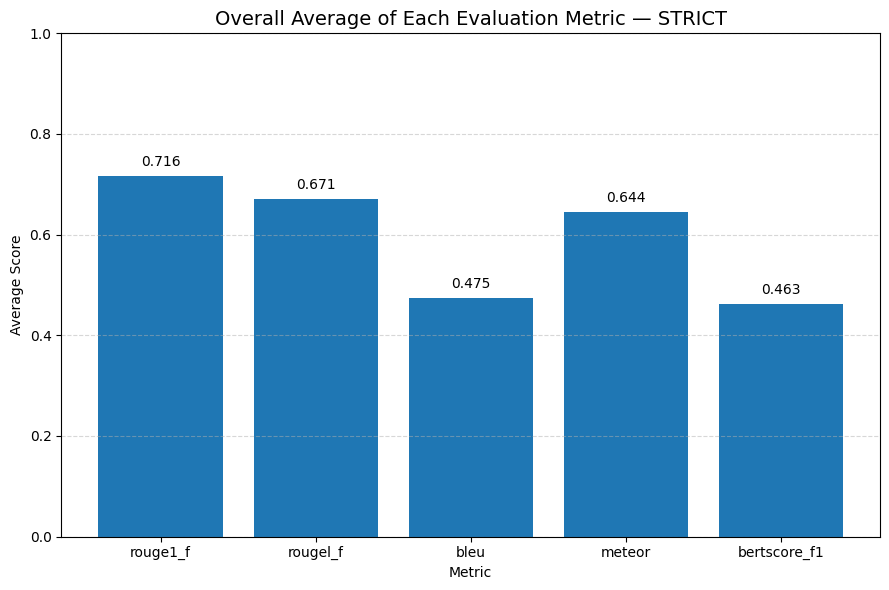

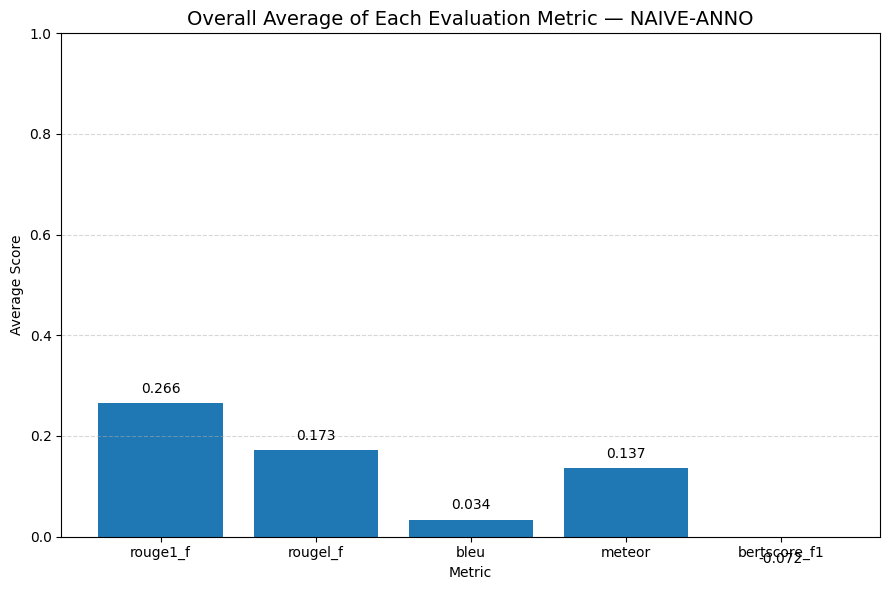

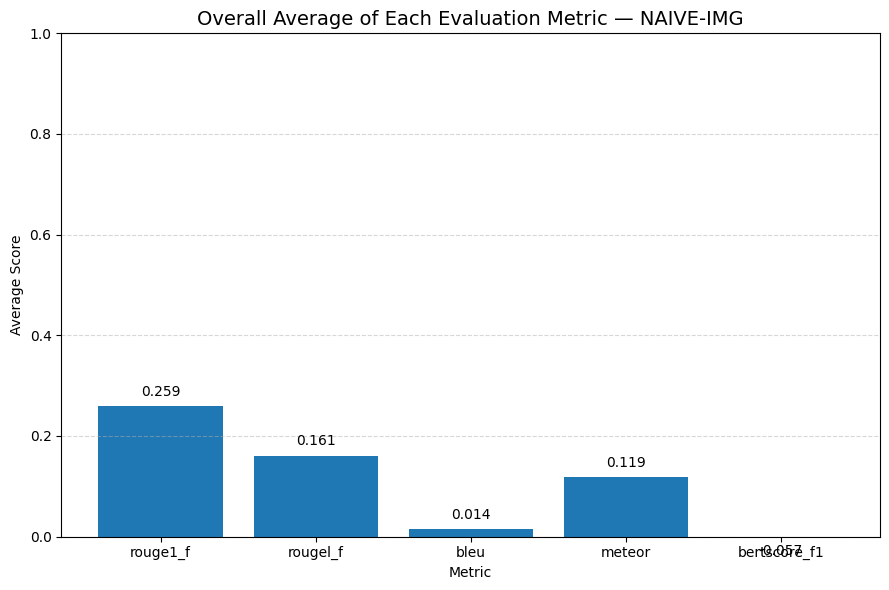

In [ ]:
import matplotlib.pyplot as plt

METRIC_COLS = ["rouge1_f", "rougel_f", "bleu", "meteor", "bertscore_f1"]

def plot_overall_averages(df, system_name):
    averages = df[METRIC_COLS].mean()

    plt.figure(figsize=(9, 6))
    bars = plt.bar(averages.index, averages.values)
    plt.title(f"Overall Average of Each Evaluation Metric — {system_name}", fontsize=14)
    plt.ylabel("Average Score")
    plt.xlabel("Metric")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # value labels
    for i, v in enumerate(averages.values):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")

    plt.tight_layout()
    plt.show()

plot_overall_averages(df_strict, "STRICT")
plot_overall_averages(df_anno,   "NAIVE-ANNO")
plot_overall_averages(df_img,    "NAIVE-IMG")


<Figure size 1000x600 with 0 Axes>

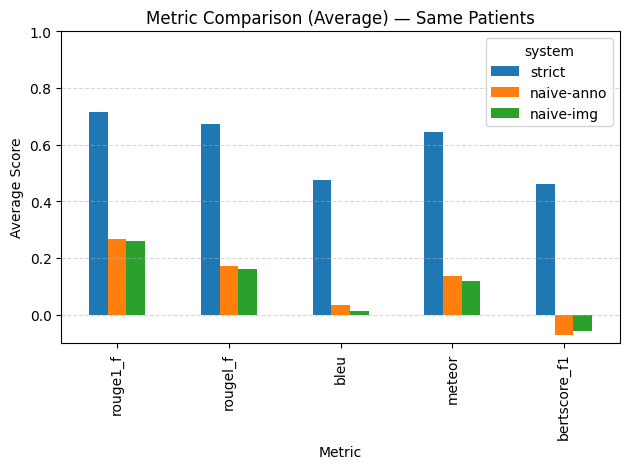

,rouge1_f,rougel_f,bleu,meteor,bertscore_f1
system,,,,,
strict,0.716010,0.671168,0.474909,0.643983,0.462781
naive-anno,0.265899,0.172770,0.033873,0.137134,-0.071802
naive-img,0.259363,0.161059,0.014086,0.118709,-0.057287


In [ ]:
summary = (all_df
           .groupby("system")[METRIC_COLS]
           .mean()
           .loc[["strict","naive-anno","naive-img"]]
          )

plt.figure(figsize=(12, 6))
summary.T.plot(kind="bar")
plt.title("Metric Comparison (Average) — Same Patients")
plt.ylabel("Average Score")
plt.xlabel("Metric")
plt.ylim(-0.1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

summary


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def plot_confusion_and_report(y_true, y_pred, title):
    LABELS = [1, 2, 3, 4, 5]  # PDF used these categories :contentReference[oaicite:4]{index=4}
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)

    print(title)
    print("Confusion Matrix (rows=true, cols=pred):\n", cm)
    print("\nClassification report:")
    print(classification_report(
        y_true, y_pred,
        labels=LABELS,
        target_names=[f"BIRADS {l}" for l in LABELS],
        zero_division=0
    ))

    plt.figure(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot(
        values_format="d",
        ax=plt.gca(),
        cmap="Blues",     # <-- change this
        colorbar=True     # <-- show the color scale
    )
    plt.title(title)
    plt.xlabel("Predicted BI-RADS")
    plt.ylabel("True BI-RADS")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
import re

def extract_birads_overall(report_text: str):
    # Looks for BI-RADS / BIRADS then a digit 1-5
    m = re.search(r"(?i)\bBI\s*[-]?\s*RADS\b[^0-9]{0,25}([1-5])", report_text)
    if not m:
        m = re.search(r"(?i)\bBIRADS\b[^0-9]{0,25}([1-5])", report_text)
    return int(m.group(1)) if m else None

def build_birads_pairs(ids_all, gt_map, pred_map):
    y_true, y_pred = [], []
    missing = []
    for pid in ids_all:
        gt_b = extract_birads_overall(gt_map[pid])
        pr_b = extract_birads_overall(pred_map[pid])
        if gt_b is None or pr_b is None:
            missing.append(pid)
            continue
        y_true.append(gt_b)
        y_pred.append(pr_b)
    print("usable:", len(y_true), "| missing:", len(missing), "| ex missing:", missing[:10])
    return y_true, y_pred

y_true_s, y_pred_s = build_birads_pairs(ids_all, gt, strict)
y_true_a, y_pred_a = build_birads_pairs(ids_all, gt, naive_anno)
y_true_i, y_pred_i = build_birads_pairs(ids_all, gt, naive_img)


usable: 33 | missing: 0 | ex missing: []
usable: 29 | missing: 4 | ex missing: [10, 102, 310, 319]
usable: 31 | missing: 2 | ex missing: [145, 209]


Confusion Matrix: BI-RADS (STRICT)
Confusion Matrix (rows=true, cols=pred):
 [[17  0  0  0  0]
 [ 0  6  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0  3  0]
 [ 0  0  0  0  1]]

Classification report:
              precision    recall  f1-score   support

    BIRADS 1       1.00      1.00      1.00        17
    BIRADS 2       1.00      1.00      1.00         6
    BIRADS 3       1.00      1.00      1.00         6
    BIRADS 4       1.00      1.00      1.00         3
    BIRADS 5       1.00      1.00      1.00         1

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



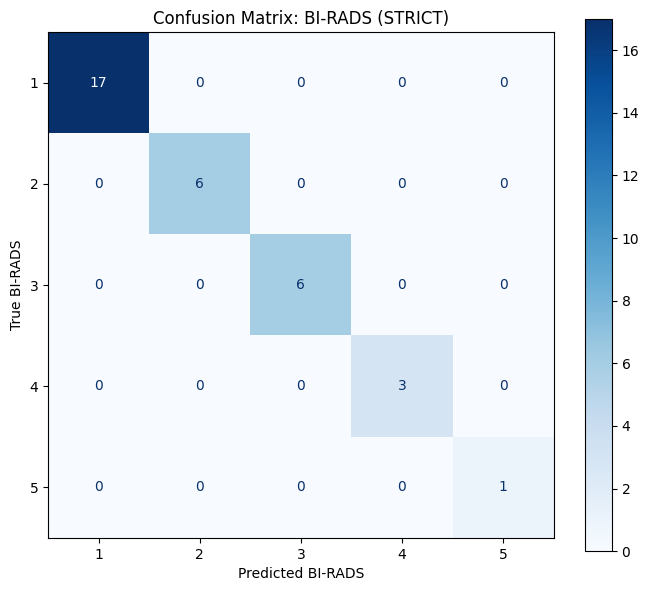

Confusion Matrix: BI-RADS (NAIVE-ANNO)
Confusion Matrix (rows=true, cols=pred):
 [[10  0  0  5  2]
 [ 0  1  0  3  0]
 [ 0  1  2  0  1]
 [ 0  0  0  2  1]
 [ 0  0  0  0  1]]

Classification report:
              precision    recall  f1-score   support

    BIRADS 1       1.00      0.59      0.74        17
    BIRADS 2       0.50      0.25      0.33         4
    BIRADS 3       1.00      0.50      0.67         4
    BIRADS 4       0.20      0.67      0.31         3
    BIRADS 5       0.20      1.00      0.33         1

    accuracy                           0.55        29
   macro avg       0.58      0.60      0.48        29
weighted avg       0.82      0.55      0.62        29



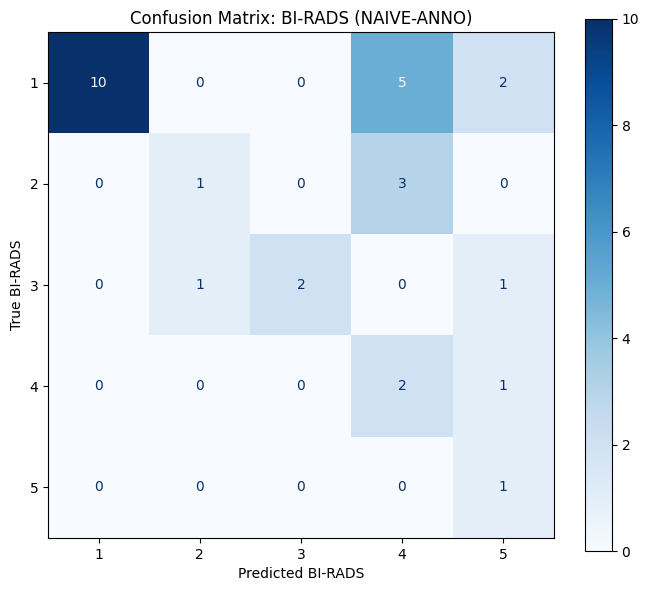

Confusion Matrix: BI-RADS (NAIVE-IMG)
Confusion Matrix (rows=true, cols=pred):
 [[6 5 0 1 4]
 [3 1 0 0 1]
 [1 4 0 0 1]
 [1 2 0 0 0]
 [0 0 0 0 1]]

Classification report:
              precision    recall  f1-score   support

    BIRADS 1       0.55      0.38      0.44        16
    BIRADS 2       0.08      0.20      0.12         5
    BIRADS 3       0.00      0.00      0.00         6
    BIRADS 4       0.00      0.00      0.00         3
    BIRADS 5       0.14      1.00      0.25         1

    accuracy                           0.26        31
   macro avg       0.15      0.32      0.16        31
weighted avg       0.30      0.26      0.26        31



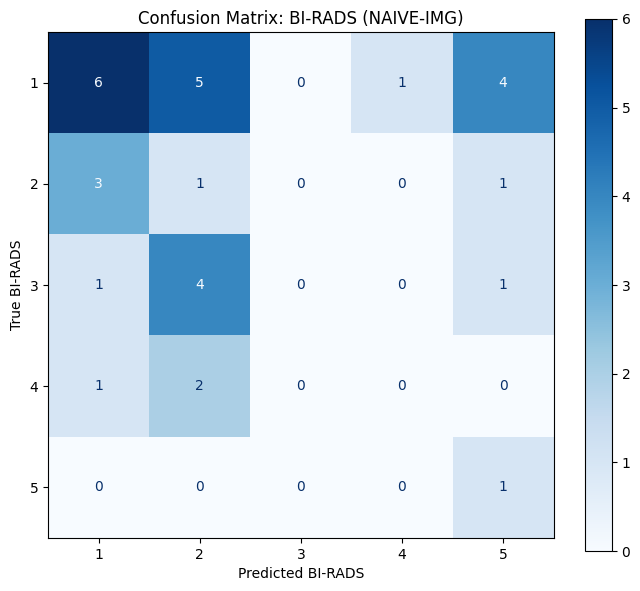

In [ ]:
plot_confusion_and_report(y_true_s, y_pred_s, "Confusion Matrix: BI-RADS (STRICT)")
plot_confusion_and_report(y_true_a, y_pred_a, "Confusion Matrix: BI-RADS (NAIVE-ANNO)")
plot_confusion_and_report(y_true_i, y_pred_i, "Confusion Matrix: BI-RADS (NAIVE-IMG)")

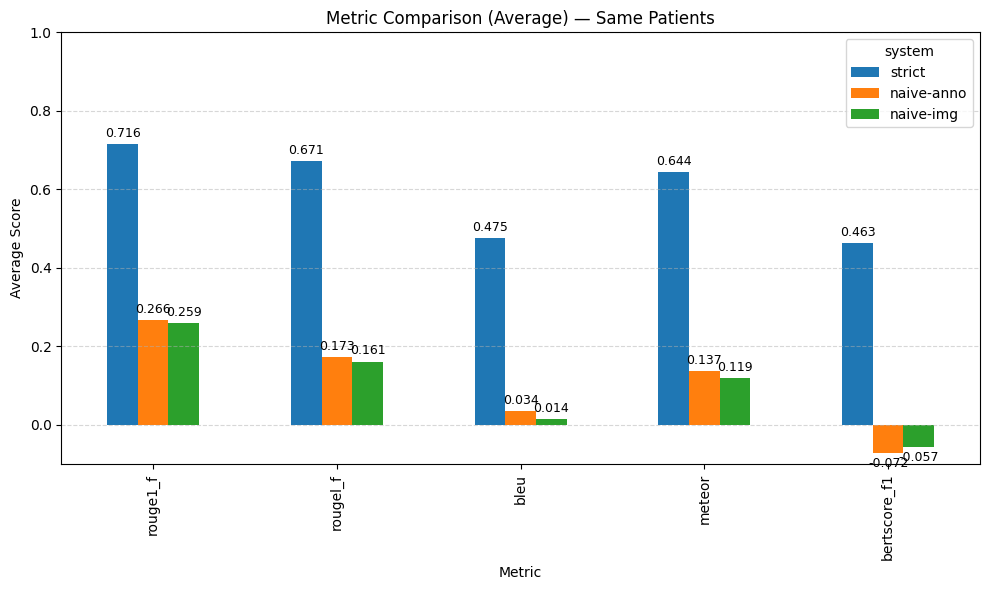

,rouge1_f,rougel_f,bleu,meteor,bertscore_f1
system,,,,,
strict,0.716010,0.671168,0.474909,0.643983,0.462781
naive-anno,0.265899,0.172770,0.033873,0.137134,-0.071802
naive-img,0.259363,0.161059,0.014086,0.118709,-0.057287


In [ ]:
METRIC_COLS = ["rouge1_f", "rougel_f", "bleu", "meteor", "bertscore_f1"]

# Build summary table (means)
summary = (all_df
           .groupby("system")[METRIC_COLS]
           .mean()
          )

order = [s for s in ["strict", "naive-anno", "naive-img"] if s in summary.index]
summary = summary.loc[order]

# --- Make BLEU comparable for plotting (0–1 instead of 0–100) ---
summary_plot = summary.copy()
if summary_plot["bleu"].max() > 1:
    summary_plot["bleu"] = summary_plot["bleu"] / 100.0

# ---- Plot grouped bars ----
ax = summary_plot.T.plot(kind="bar", figsize=(10, 6))  # metrics on x-axis, systems in legend

ax.set_title("Metric Comparison (Average) — Same Patients")
ax.set_xlabel("Metric")
ax.set_ylabel("Average Score")
ax.set_ylim(-0.1, 1)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# ---- Add value labels on each bar ----
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

summary


In [ ]:
from sklearn.metrics import accuracy_score

labels_with_unknown = [1,2,3,4,5]
labels_no_unknown   = [1,2,3,4,5]

def birads_accuracy(system_name, pred_map, ids):
    # With Unknown=0 (missing preds become 0)
    y_true_u, y_pred_u, cov = build_birads_pairs(ids, gt, pred_map, include_unknown=True)
    acc_unknown = accuracy_score(y_true_u, y_pred_u)

    # Present-only (drop missing preds)
    y_true_p, y_pred_p, _ = build_birads_pairs(ids, gt, pred_map, include_unknown=False)
    acc_present = accuracy_score(y_true_p, y_pred_p) if len(y_true_p) else float("nan")

    return {
        "system": system_name,
        "n_patients": len(ids),
        "coverage_%": cov * 100,  # % where BI-RADS was present
        "acc_with_unknown_%": acc_unknown * 100,
        "acc_present_only_%": acc_present * 100,
        "present_only_count": len(y_true_p),
    }

# Use the same patients across all 3 (recommended)
ids_3 = sorted([pid for pid in test_ids if pid in gt and pid in strict and pid in naive_anno and pid in naive_img])
print("Same-patient set size (3 systems):", len(ids_3))

rows = []
rows.append(birads_accuracy("strict", strict, ids_3))
rows.append(birads_accuracy("naive-anno", naive_anno, ids_3))
rows.append(birads_accuracy("naive-img", naive_img, ids_3))

acc_df = pd.DataFrame(rows)
acc_df

Same-patient set size (3 systems): 33


,system,n_patients,coverage_%,acc_with_unknown_%,acc_present_only_%,present_only_count
0,strict,33,100.000000,100.000000,100.000000,33
1,naive-anno,33,93.939394,45.454545,48.387097,31
2,naive-img,33,100.000000,24.242424,24.242424,33


In [ ]:
for _, r in acc_df.iterrows():
    print(
        f"{r['system']:10s} | "
        f"coverage={r['coverage_%']:.1f}% | "
        f"acc(with Unknown)={r['acc_with_unknown_%']:.1f}% | "
        f"acc(present-only)={r['acc_present_only_%']:.1f}% "
        f"(n_present={int(r['present_only_count'])}/{int(r['n_patients'])})"
    )


strict     | coverage=100.0% | acc(with Unknown)=100.0% | acc(present-only)=100.0% (n_present=33/33)
naive-anno | coverage=93.9% | acc(with Unknown)=45.5% | acc(present-only)=48.4% (n_present=31/33)
naive-img  | coverage=100.0% | acc(with Unknown)=24.2% | acc(present-only)=24.2% (n_present=33/33)


In [ ]:
OUT_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output_JSON"
os.makedirs(OUT_DIR, exist_ok=True)

all_df = pd.concat([df_strict, df_anno, df_img], ignore_index=True)

summary = (all_df
           .groupby("system")[["rouge1_f","rougel_f","bleu","meteor","bertscore_f1"]]
           .mean()
           .sort_index())

print("Same-patient evaluation size:", len(ids_all))
display(summary)

all_df.to_csv(os.path.join(OUT_DIR, "metrics_same_patients_all_systems.csv"), index=False)
summary.to_csv(os.path.join(OUT_DIR, "metrics_summary_same_patients.csv"))
print("Saved to:", OUT_DIR)


Same-patient evaluation size: 33


,rouge1_f,rougel_f,bleu,meteor,bertscore_f1
system,,,,,
naive-anno,0.265899,0.172770,0.033873,0.137134,-0.071802
naive-img,0.259363,0.161059,0.014086,0.118709,-0.057287
strict,0.716010,0.671168,0.474909,0.643983,0.462781


Saved to: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output_JSON


#Confusion Matrix

In [ ]:
# === Single source of truth for folders ===
GT_DIR         = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Medical reports for cases"
STRICT_DIR     = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2"
NAIVE_ANNO_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive-anno"
NAIVE_IMG_DIR  = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-naive-image"

# === Backwards-compatible aliases (so older cells still work) ===
NAIVE_ANNO_OUTPUT  = NAIVE_ANNO_DIR
NAIVE_IMAGE_OUTPUT = NAIVE_IMG_DIR
OUTPUT_IMG_DIR     = NAIVE_IMG_DIR  # you used this alias later for direct_img :contentReference[oaicite:2]{index=2}

print("GT exists:", os.path.exists(GT_DIR))
print("naive-anno exists:", os.path.exists(NAIVE_ANNO_DIR))
print("naive-img exists:", os.path.exists(NAIVE_IMG_DIR))
print("strict-output exists:", os.path.exists(STRICT_DIR))

GT exists: True
naive-anno exists: True
naive-img exists: True
strict-output exists: True


In [ ]:
import os, re
from docx import Document

def read_docx_text(path: str) -> str:
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs).strip()

def extract_pid_from_filename(filename: str):
    m = re.search(r"(?i)P0*(\d+)", filename)
    return int(m.group(1)) if m else None

def load_reports(folder: str):
    out = {}
    if not os.path.exists(folder):
        return out

    for fn in os.listdir(folder):
        # ✅ skip Word temp/lock files + hidden files
        if fn.startswith("~$") or fn.startswith("."):
            continue

        # only docx/txt
        if not (fn.lower().endswith(".docx") or fn.lower().endswith(".txt")):
            continue

        pid = extract_pid_from_filename(fn)
        if pid is None:
            continue

        path = os.path.join(folder, fn)

        try:
            if fn.lower().endswith(".docx"):
                out[pid] = read_docx_text(path)
            else:
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    out[pid] = f.read().strip()
        except Exception as e:
            print(f"Skipping unreadable file: {fn} | {type(e).__name__}")
            continue

    return out

In [ ]:
gt         = load_reports(GT_DIR)
naive_anno = load_reports(NAIVE_ANNO_DIR)
naive_img  = load_reports(NAIVE_IMG_DIR)
strict     = load_reports(STRICT_DIR)

print("GT:", len(gt))
print("naive-anno:", len(naive_anno))
print("naive-img:", len(naive_img))
print("strict:", len(strict))

GT: 326
naive-anno: 33
naive-img: 33
strict: 326


In [ ]:
import re

def extract_birads_overall(text: str):
    # Try standard BI-RADS formats
    m = re.search(r"(?i)\bBI\s*[-]?\s*RADS\b[^0-9]{0,25}([0-6])", text or "")
    if not m:
        m = re.search(r"(?i)\bBIRADS\b[^0-9]{0,25}([0-6])", text or "")
    return int(m.group(1)) if m else None

In [ ]:
def build_birads_pairs(ids, gt_map, pred_map, include_unknown=True):
    """
    include_unknown=True  -> map missing pred to 0 (Unknown)
    include_unknown=False -> drop rows where pred is missing
    """
    y_true, y_pred = [], []
    missing_pred = 0

    for pid in ids:
        gt_b = extract_birads_overall(gt_map[pid])
        pr_b = extract_birads_overall(pred_map[pid])

        if gt_b is None:
            continue  # (rare) skip if GT missing

        if pr_b is None:
            missing_pred += 1
            if include_unknown:
                pr_b = 0
            else:
                continue

        y_true.append(gt_b)
        y_pred.append(pr_b)

    coverage = 1 - (missing_pred / len([pid for pid in ids if pid in gt_map]))
    return y_true, y_pred, coverage

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(6, 5))
    ax = plt.gca()
    disp.plot(values_format="d", ax=ax, cmap="Blues", colorbar=True)
    plt.title(title)
    plt.xlabel("Predicted BI-RADS")
    plt.ylabel("True BI-RADS")
    plt.tight_layout()
    plt.show()

    return cm

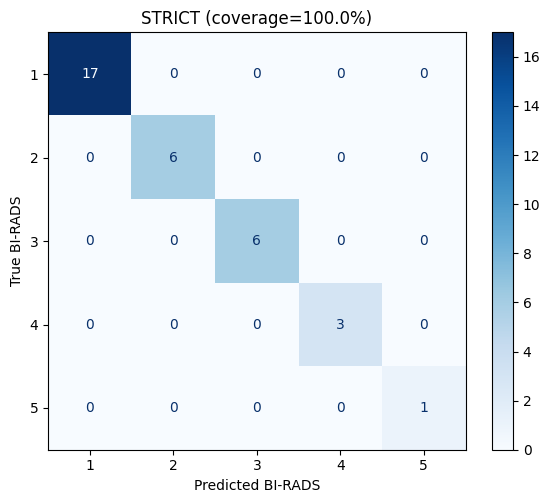

array([[17,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0],
       [ 0,  0,  6,  0,  0],
       [ 0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  1]])

In [ ]:
labels_no_unknown = [1,2,3,4,5]
yts, yps, cov_s = build_birads_pairs(ids_all, gt, strict, include_unknown=False)
plot_cm(yts, yps, labels_no_unknown, f"STRICT (coverage={cov_s*100:.1f}%)")

In [ ]:
direct_img = load_reports(OUTPUT_IMG_DIR)
print("direct_img loaded:", len(direct_img))
print("example patient IDs:", list(direct_img.keys())[:10])

direct_img loaded: 33
example patient IDs: [4, 6, 10, 43, 46, 56, 58, 61, 64, 74]


Same-patient set size (3 systems): 33


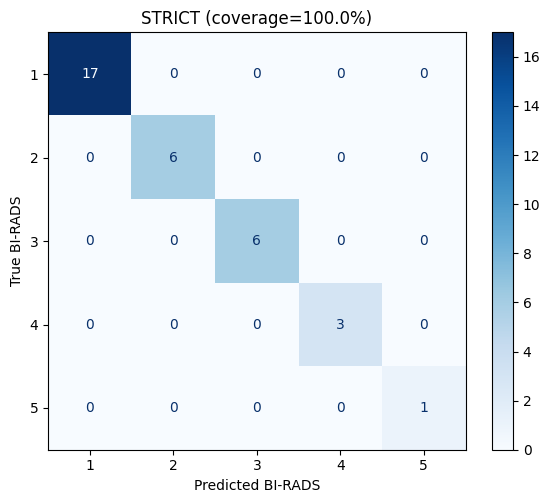

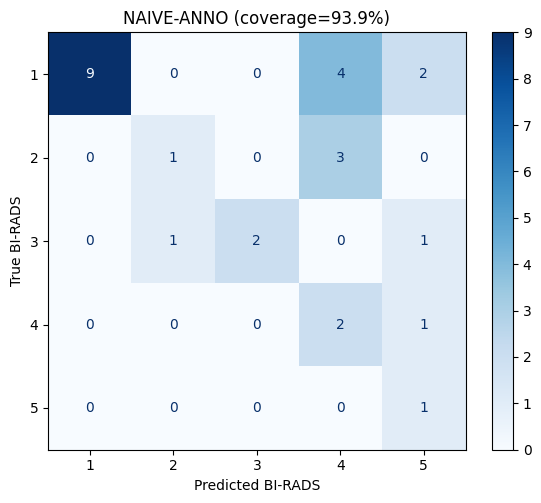

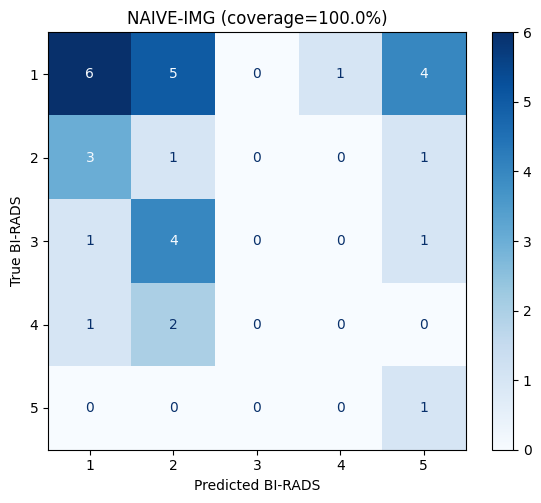

In [ ]:
# 1) Choose SAME patients across all 3 systems + GT
ids_all = sorted([
    pid for pid in test_ids
    if pid in gt and pid in strict and pid in naive_anno and pid in naive_img
])
print("Same-patient set size (3 systems):", len(ids_all))

# 2) Plot confusion matrices for each system
labels_no_unknown = [1,2,3,4,5]

systems = [
    ("STRICT", strict),
    ("NAIVE-ANNO", naive_anno),
    ("NAIVE-IMG", naive_img),
]

for name, pred_map in systems:
    y_true, y_pred, coverage = build_birads_pairs(ids_all, gt, pred_map, include_unknown=False)
    plot_cm(y_true, y_pred, labels_no_unknown, f"{name} (coverage={coverage*100:.1f}%)")

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Same patients across all 3 systems + GT
ids_all = sorted([
    pid for pid in test_ids
    if pid in gt and pid in strict and pid in naive_anno and pid in naive_img
])
print("Same-patient set size (3 systems):", len(ids_all))

def birads_accuracy_present_only(ids, gt_map, pred_map):
    y_true, y_pred, coverage = build_birads_pairs(ids, gt_map, pred_map, include_unknown=False)
    acc = accuracy_score(y_true, y_pred) if len(y_true) else float("nan")
    return acc, coverage, len(y_true)

rows = []
systems = [
    ("STRICT", strict),
    ("NAIVE-ANNO", naive_anno),
    ("NAIVE-IMG", naive_img),
]

for name, pred_map in systems:
    acc, cov, n_used = birads_accuracy_present_only(ids_all, gt, pred_map)
    rows.append({
        "system": name,
 #       "n_total_same_patients": len(ids_all),
 #       "n_used_present_only": n_used,
        "coverage_%": cov * 100,
        "birads_accuracy_%": acc * 100,
    })

acc_df = pd.DataFrame(rows)
acc_df

Same-patient set size (3 systems): 33


,system,coverage_%,birads_accuracy_%
0,STRICT,100.000000,100.000000
1,NAIVE-ANNO,93.939394,48.387097
2,NAIVE-IMG,100.000000,24.242424


# let's fix up BERTScore for a moment

In [ ]:
from bert_score import score as bert_score_fn
import numpy as np

def bertscore_mean(hyps, refs, rescale):
    P, R, F1 = bert_score_fn(hyps, refs, lang="en", rescale_with_baseline=rescale)
    return float(F1.mean()), float(F1.min()), float(F1.max())

# build aligned lists for the SAME patients
def aligned_lists(ids, gt_map, pred_map):
    refs = [gt_map[i] for i in ids]
    hyps = [pred_map[i] for i in ids]
    return hyps, refs

hyps_a, refs_a = aligned_lists(ids_all, gt, naive_anno)
hyps_i, refs_i = aligned_lists(ids_all, gt, naive_img)
hyps_s, refs_s = aligned_lists(ids_all, gt, strict)

for name, hyps, refs in [
    ("naive-anno", hyps_a, refs_a),
    ("naive-img",  hyps_i, refs_i),
    ("strict",     hyps_s, refs_s),
]:
    mean_u, min_u, max_u = bertscore_mean(hyps, refs, rescale=False)
    mean_r, min_r, max_r = bertscore_mean(hyps, refs, rescale=True)
    print(f"{name:10s}  unrescaled: mean={mean_u:.3f} min={min_u:.3f} max={max_u:.3f} | rescaled: mean={mean_r:.3f} min={min_r:.3f} max={max_r:.3f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


naive-anno  unrescaled: mean=0.819 min=0.806 max=0.834 | rescaled: mean=-0.072 min=-0.150 max=0.014


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


naive-img   unrescaled: mean=0.822 min=0.809 max=0.834 | rescaled: mean=-0.057 min=-0.133 max=0.018


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


strict      unrescaled: mean=0.909 min=0.881 max=0.933 | rescaled: mean=0.463 min=0.294 max=0.601


In [ ]:
missing_strict = [pid for pid in test_ids if pid in gt and pid not in strict]
missing_anno   = [pid for pid in test_ids if pid in gt and pid not in naive_anno]
missing_img    = [pid for pid in test_ids if pid in gt and pid not in naive_img]

print("Missing strict:", len(missing_strict), missing_strict[:10])
print("Missing anno:  ", len(missing_anno),   missing_anno[:10])
print("Missing img:   ", len(missing_img),    missing_img[:10])

Missing strict: 0 []
Missing anno:   0 []
Missing img:    0 []


In [ ]:
from bert_score import score as bert_score_fn

P, R, F1 = bert_score_fn(hyps_a, refs_a, lang="en", rescale_with_baseline=True)

idx_sorted = sorted(range(len(ids_all)), key=lambda k: float(F1[k]))
for k in idx_sorted[:5]:
    pid = ids_all[k]
    print("\nPID:", pid, "BERT-F1(rescaled):", float(F1[k]))
    print("GT chars:", len(gt[pid]), "PRED chars:", len(naive_anno[pid]))
    print("PRED preview:", naive_anno[pid][:200].replace("\n"," "))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



PID: 64 BERT-F1(rescaled): -0.1501574069261551
GT chars: 711 PRED chars: 1702
PRED preview: Diagnostic Breast Imaging Report  Indication: Cannot determine. Comparison: Cannot determine. Technique/Modality: Cannot determine. Breast Composition: Cannot determine.  Findings: - Mass #1: Equal de

PID: 275 BERT-F1(rescaled): -0.1489439457654953
GT chars: 813 PRED chars: 1741
PRED preview: Below are BI-RADS–compliant reports for each distinct finding set provided.  Report 1 - Indication: Cannot determine. - Comparison: Cannot determine. - Technique: Cannot determine. - Findings: Normal.

PID: 319 BERT-F1(rescaled): -0.1360401064157486
GT chars: 1006 PRED chars: 1731
PRED preview: Exam: Cannot determine (findings span multiple modalities) Clinical indication: Cannot determine Comparison: Cannot determine Breast composition: Cannot determine  Findings: - Mammographic features:  

PID: 102 BERT-F1(rescaled): -0.12069769203662872
GT chars: 684 PRED chars: 1380
PRED preview: Breast Imaging Repor

#Data Visualization

##"rouge1_f","rougel_f","bleu","meteor","bertscore_f1"

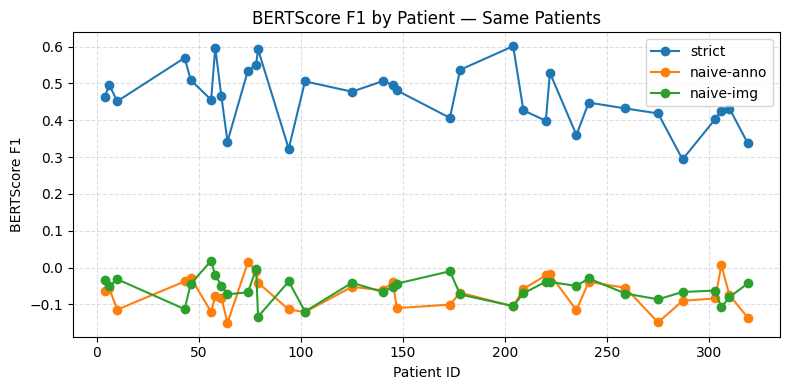

,patient_id,strict,naive-anno,naive-img
0,4,0.464339,-0.064606,-0.033890
1,6,0.496763,-0.055993,-0.049756
2,10,0.451737,-0.114056,-0.031686
3,43,0.569667,-0.037658,-0.112745
4,46,0.509203,-0.027301,-0.043905


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Build per-patient table (must include patient_id col)
s = df_strict[["patient_id","bertscore_f1"]].rename(columns={"bertscore_f1":"strict"})
a = df_anno[["patient_id","bertscore_f1"]].rename(columns={"bertscore_f1":"naive-anno"})
i = df_img[["patient_id","bertscore_f1"]].rename(columns={"bertscore_f1":"naive-img"})

per_patient = s.merge(a, on="patient_id").merge(i, on="patient_id").sort_values("patient_id")

plt.figure(figsize=(8, 4))
plt.plot(per_patient["patient_id"], per_patient["strict"], marker="o", label="strict")
plt.plot(per_patient["patient_id"], per_patient["naive-anno"], marker="o", label="naive-anno")
plt.plot(per_patient["patient_id"], per_patient["naive-img"], marker="o", label="naive-img")

plt.title("BERTScore F1 by Patient — Same Patients")
plt.xlabel("Patient ID")
plt.ylabel("BERTScore F1")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

per_patient.head()

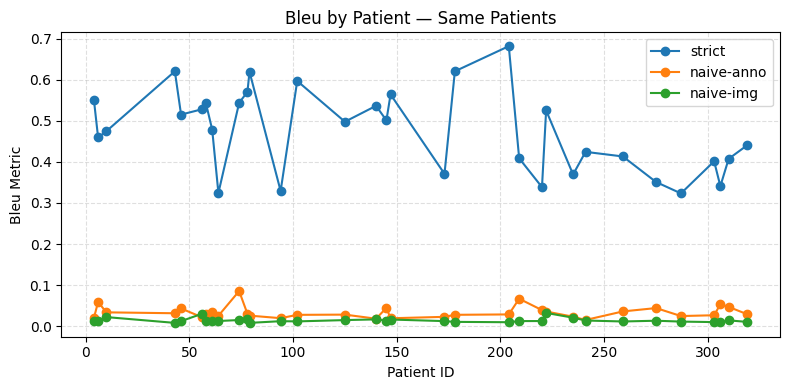

,patient_id,strict,naive-anno,naive-img
0,4,0.550189,0.020358,0.011502
1,6,0.459543,0.058866,0.013159
2,10,0.474778,0.033697,0.022138
3,43,0.620597,0.031480,0.008028
4,46,0.515210,0.043127,0.012264


In [ ]:
s = df_strict[["patient_id","bleu"]].rename(columns={"bleu":"strict"})
a = df_anno[["patient_id","bleu"]].rename(columns={"bleu":"naive-anno"})
i = df_img[["patient_id","bleu"]].rename(columns={"bleu":"naive-img"})

per_patient = s.merge(a, on="patient_id").merge(i, on="patient_id").sort_values("patient_id")

plt.figure(figsize=(8, 4))
plt.plot(per_patient["patient_id"], per_patient["strict"], marker="o", label="strict")
plt.plot(per_patient["patient_id"], per_patient["naive-anno"], marker="o", label="naive-anno")
plt.plot(per_patient["patient_id"], per_patient["naive-img"], marker="o", label="naive-img")

plt.title("Bleu by Patient — Same Patients")
plt.xlabel("Patient ID")
plt.ylabel("Bleu Metric")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

per_patient.head()

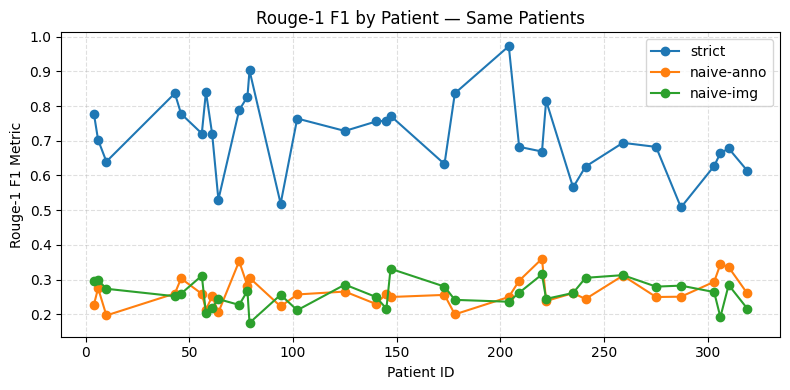

,patient_id,strict,naive-anno,naive-img
0,4,0.777070,0.228188,0.295082
1,6,0.702439,0.275304,0.298780
2,10,0.640000,0.196891,0.273684
3,43,0.836735,0.260000,0.252252
4,46,0.777778,0.303448,0.259542


In [ ]:
s = df_strict[["patient_id","rouge1_f"]].rename(columns={"rouge1_f":"strict"})
a = df_anno[["patient_id","rouge1_f"]].rename(columns={"rouge1_f":"naive-anno"})
i = df_img[["patient_id","rouge1_f"]].rename(columns={"rouge1_f":"naive-img"})

per_patient = s.merge(a, on="patient_id").merge(i, on="patient_id").sort_values("patient_id")

plt.figure(figsize=(8, 4))
plt.plot(per_patient["patient_id"], per_patient["strict"], marker="o", label="strict")
plt.plot(per_patient["patient_id"], per_patient["naive-anno"], marker="o", label="naive-anno")
plt.plot(per_patient["patient_id"], per_patient["naive-img"], marker="o", label="naive-img")

plt.title("Rouge-1 F1 by Patient — Same Patients")
plt.xlabel("Patient ID")
plt.ylabel("Rouge-1 F1 Metric")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

per_patient.head()

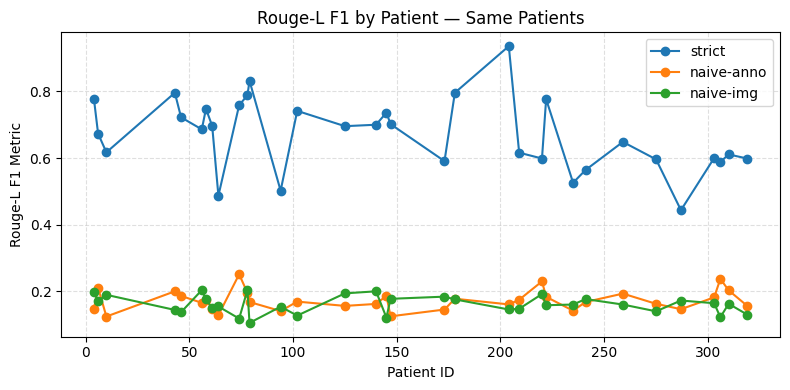

,patient_id,strict,naive-anno,naive-img
0,4,0.777070,0.147651,0.196721
1,6,0.673171,0.210526,0.170732
2,10,0.617143,0.124352,0.189474
3,43,0.795918,0.200000,0.144144
4,46,0.722222,0.186207,0.137405


In [ ]:
s = df_strict[["patient_id","rougel_f"]].rename(columns={"rougel_f":"strict"})
a = df_anno[["patient_id","rougel_f"]].rename(columns={"rougel_f":"naive-anno"})
i = df_img[["patient_id","rougel_f"]].rename(columns={"rougel_f":"naive-img"})

per_patient = s.merge(a, on="patient_id").merge(i, on="patient_id").sort_values("patient_id")

plt.figure(figsize=(8, 4))
plt.plot(per_patient["patient_id"], per_patient["strict"], marker="o", label="strict")
plt.plot(per_patient["patient_id"], per_patient["naive-anno"], marker="o", label="naive-anno")
plt.plot(per_patient["patient_id"], per_patient["naive-img"], marker="o", label="naive-img")

plt.title("Rouge-L F1 by Patient — Same Patients")
plt.xlabel("Patient ID")
plt.ylabel("Rouge-L F1 Metric")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

per_patient.head()

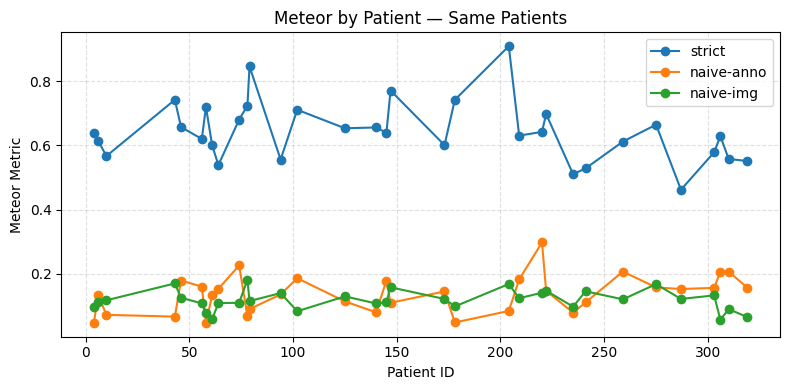

,patient_id,strict,naive-anno,naive-img
0,4,0.637970,0.048019,0.097254
1,6,0.614866,0.135040,0.113671
2,10,0.566819,0.072314,0.117675
3,43,0.742123,0.066794,0.170131
4,46,0.657100,0.179271,0.125502


In [ ]:
s = df_strict[["patient_id","meteor"]].rename(columns={"meteor":"strict"})
a = df_anno[["patient_id","meteor"]].rename(columns={"meteor":"naive-anno"})
i = df_img[["patient_id","meteor"]].rename(columns={"meteor":"naive-img"})

per_patient = s.merge(a, on="patient_id").merge(i, on="patient_id").sort_values("patient_id")

plt.figure(figsize=(8, 4))
plt.plot(per_patient["patient_id"], per_patient["strict"], marker="o", label="strict")
plt.plot(per_patient["patient_id"], per_patient["naive-anno"], marker="o", label="naive-anno")
plt.plot(per_patient["patient_id"], per_patient["naive-img"], marker="o", label="naive-img")

plt.title("Meteor by Patient — Same Patients")
plt.xlabel("Patient ID")
plt.ylabel("Meteor Metric")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

per_patient.head()

In [ ]:
"meteor"

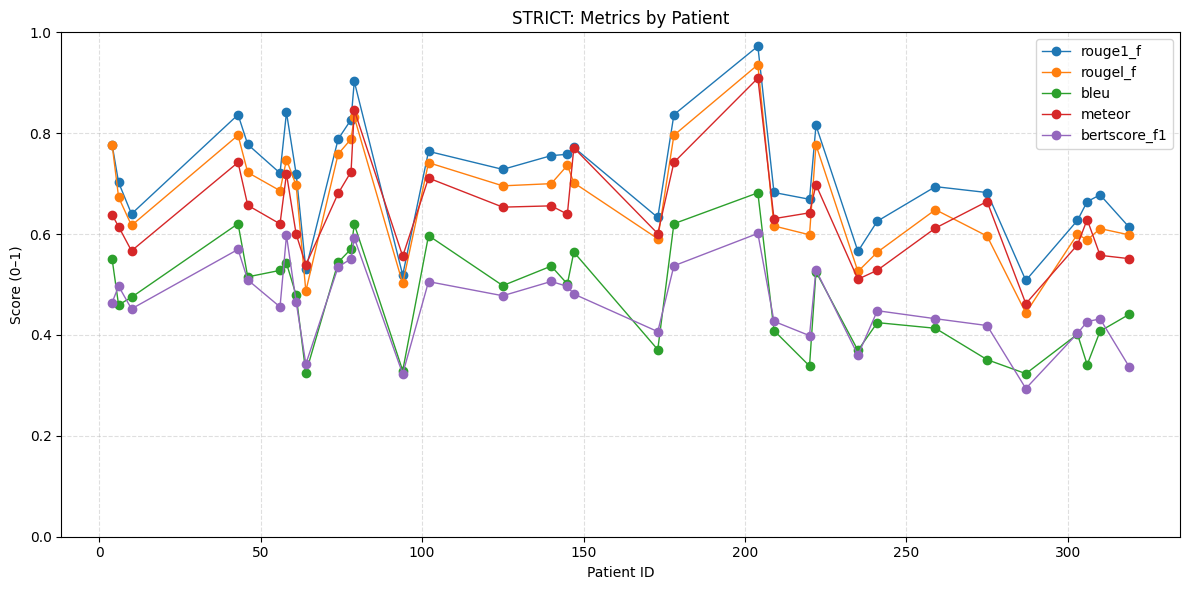

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# df_strict must have: patient_id, rouge1_f, rougel_f, bleu, meteor, bertscore_f1

def plot_metrics_for_prompt(df, prompt_name="STRICT", smooth=False, window=5):
    dfp = df.copy().sort_values("patient_id")

    # --- make BLEU comparable (0–1 instead of 0–100) ---
    if dfp["bleu"].max() > 1:
        dfp["bleu"] = dfp["bleu"] / 100.0

    # --- optional smoothing (rolling average) ---
    metric_cols = ["rouge1_f", "rougel_f", "bleu", "meteor", "bertscore_f1"]
    plot_df = dfp[["patient_id"] + metric_cols].copy()

    if smooth:
        for c in metric_cols:
            plot_df[c] = plot_df[c].rolling(window=window, min_periods=1).mean()

    # --- plot ---
    plt.figure(figsize=(12, 6))
    for c in metric_cols:
        plt.plot(plot_df["patient_id"], plot_df[c], marker="o", linewidth=1, label=c)

    title = f"{prompt_name}: Metrics by Patient" + (f" (rolling mean, window={window})" if smooth else "")
    plt.title(title)
    plt.xlabel("Patient ID")
    plt.ylabel("Score (0–1)")
    plt.ylim(0, 1)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run for STRICT
plot_metrics_for_prompt(df_strict, "STRICT", smooth=False)

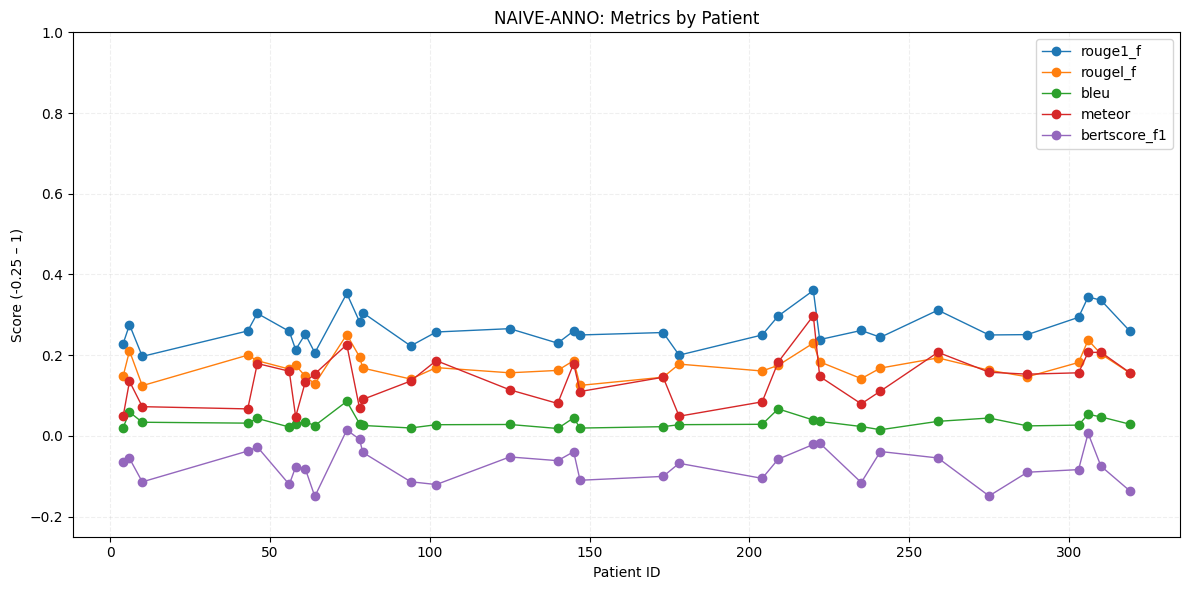

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_for_prompt(df, prompt_name="NAIVE-ANNO", smooth=False, window=5):
    dfp = df.copy().sort_values("patient_id")

    # --- make BLEU comparable (0–1 instead of 0–100) ---
    if dfp["bleu"].max() > 1:
        dfp["bleu"] = dfp["bleu"] / 100.0

    # --- optional smoothing (rolling average) ---
    metric_cols = ["rouge1_f", "rougel_f", "bleu", "meteor", "bertscore_f1"]
    plot_df = dfp[["patient_id"] + metric_cols].copy()

    if smooth:
        for c in metric_cols:
            plot_df[c] = plot_df[c].rolling(window=window, min_periods=1).mean()

    # --- plot ---
    plt.figure(figsize=(12, 6))
    for c in metric_cols:
        plt.plot(plot_df["patient_id"], plot_df[c], marker="o", linewidth=1, label=c)

    title = f"{prompt_name}: Metrics by Patient" + (f" (rolling mean, window={window})" if smooth else "")
    plt.title(title)
    plt.xlabel("Patient ID")
    plt.ylabel("Score (-0.25 – 1)")
    plt.ylim(-0.25, 1)
    plt.grid(True, linestyle="--", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run for STRICT
plot_metrics_for_prompt(df_anno, "NAIVE-ANNO", smooth=False)


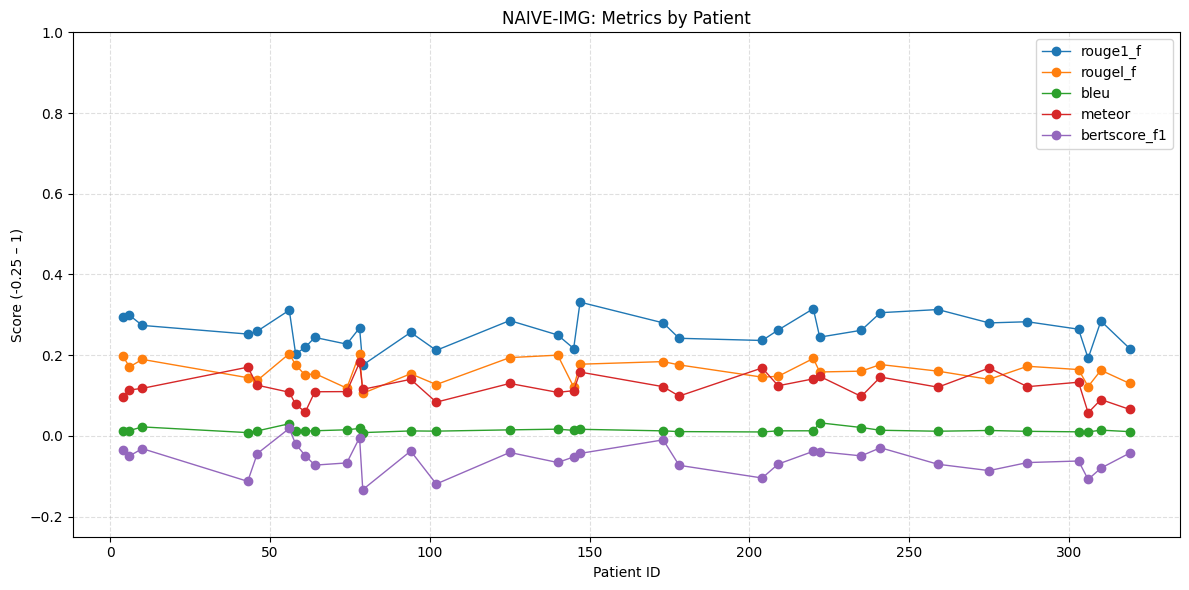

In [ ]:
def plot_metrics_for_prompt(df, prompt_name="NAIVE-IMG", smooth=False, window=5):
    dfp = df.copy().sort_values("patient_id")

    # --- make BLEU comparable (0–1 instead of 0–100) ---
    if dfp["bleu"].max() > 1:
        dfp["bleu"] = dfp["bleu"] / 100.0

    # --- optional smoothing (rolling average) ---
    metric_cols = ["rouge1_f", "rougel_f", "bleu", "meteor", "bertscore_f1"]
    plot_df = dfp[["patient_id"] + metric_cols].copy()

    if smooth:
        for c in metric_cols:
            plot_df[c] = plot_df[c].rolling(window=window, min_periods=1).mean()

    # --- plot ---
    plt.figure(figsize=(12, 6))
    for c in metric_cols:
        plt.plot(plot_df["patient_id"], plot_df[c], marker="o", linewidth=1, label=c)

    title = f"{prompt_name}: Metrics by Patient" + (f" (rolling mean, window={window})" if smooth else "")
    plt.title(title)
    plt.xlabel("Patient ID")
    plt.ylabel("Score (-0.25 – 1)")
    plt.ylim(-0.25, 1)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run for STRICT
plot_metrics_for_prompt(df_img, "NAIVE-IMG", smooth=False)